# Calcul des facteurs de forme atomiques pour la diffusion des rayons X 

## Définitions:

Le facteur de forme atomique (rayons X) correspond à l'amplitude de diffusion résonante des rayons X par une densité de charge (ici les électrons primaires du nuage électronique des atomes irradiés). Le facteur de forme dépend:
- de l'énergie des rayons X incidents caractérisée par une longueur d'onde $\lambda$, 
- du numéro atomique Z des atomes irradiés
- de l'angle d'observation $\theta$, représenté par le vecteur du réseau réciproque $q=4\pi sin(\theta)/\lambda$.

Il s'agit d'un nombre complexe qui peut s'écrire sous la forme suivante( https://physics.nist.gov/PhysRefData/FFast/Text2000/sec02.html#eq04):

$f(q,\lambda)=f_0(q)+f'(\lambda)+f_{NT} +if''(\lambda)$ (1)

- Le terme $f_0(q)$ représente l'évolution du facteur de forme avec l'angle d'observation. On a classiquement $f_0(q=0)=Z$
- le terme $f'(\lambda)$ est le facteur de diffusion anomale
- le terme $f_{NT}$ correpond au petit terme nucléaire Thomson, fourni par la base de données NIST
- le terme $f''(\lambda)$ est directement relié à la section efficace atomique de photoabsorption. Il correspond directement au terme $f_2$ fourni par NIST

Le terme $f'(\lambda)$ peut se décomposer comme suit:
$f'(\lambda)=f_1(\lambda)+f_{rel}-Z$ (2)

- $f_1(\lambda)$ est un terme qui est accessibe sur la base de données NIST
- $f_{rel}$ est un (faible) terme de correction relativiste également fourni par NIST
- le terme $f''(\lambda)=f_2(\lambda)$ est accessible depuis la base de données NIST

L'équation 2 devient alors:

$f(q,\lambda)=f_0(q)+f_1(\lambda)+f_{rel}-Z+f_{NT}+if_2(\lambda)$ (3)

## Calcul de $f_0$

Le terme $f_0$ traduit la dépendance angulaire du facteur de diffusion des atomes (il est également appelé terme non dispersif, car indépendant de l'énergie du faisceau incident). L'évolution angulaire de ce terme peut se calculer en utilisant la formule suivante:

$f_0(q)=\sum \limits _{i=1}^4 a_i.exp(-b_iq²)+c$ (5)

où les termes $a_i$, $b_i$ et c sont les coefficients de Cromer-Mann, fournis dans les tables internationales de cristallographie.

### Calcul de $f_0$ dans Python

On fait appel à la bibliothèque xraydb (https://xraypy.github.io/XrayDB/python.html). Il y a une fonction qui permet de calculer le terme f0 pour une espèce atomique donnée dans une gamme de valeurs de q définie par l'uilisateur. On va donc écrire ici une fonction qui permet de retourner les valeurs $f_0(q)$ pour un élément donné (défini par son symbole issu de la classification périodique). 

####  Import des bibliothèques - Défintion de variables test

In [1]:
import xraydb
import numpy as np
# bibliothèques utiles pour le calcul de f1
import functools
import requests
from io import StringIO
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from matplotlib import pyplot as plt
import numba as nb
import math

# Définition de la gamme de q sur laquelle on teste les fonctions
qmin=0.01
qmax=20
qstep=0.01


# Définition de l'espèce atomique pour laquelle on calcule le facteur de diffusion
element='Pt'

# Définition de la longueur d'onde
wavelength=0.7107

#### Fonction pour le calcul de f0

In [2]:
def _f0(qmin,qmax,qstep,element):
    qarray=np.arange(qmin,qmax,qstep)
    f=xraydb.f0(element,qarray)
    return f


### Calcul des termes $f_1(\lambda)$, $f_{rel}$, $f_{NT}$ et $f_2(\lambda)$

Ces coefficients sont accessibles depuis la base de données NIST.
Dans un premier temps, il convient de récupérer la dépendance des termes $f_1$ et $f_2$ avec l'énergie. Pour ce faire, on adapte une fonction disponible sur github à l'adresse suivante (https://gist.github.com/skuschel/ffc7bcbfd095d3feda40d21951b02491). 
La fonction initialement proposée renvoie 2 tableaux, l'un correspondant à l'énergie, en eV, l'autre au terme $f=f_1+if_2$. On va chercher les valeurs de $f_1$ et $f_2$ correspondant à l'énergie du faisceau de rayons X utilisé. Dans notre cas, on utilise la raie $K_{\alpha}$ produite par une anode Mo ($\lambda=0.071nm$. L'énergie correspondante est $E=17 326.58eV$

Dans le code python, 2 options se présentent:
- soit on cherche la valeur d'énergie la plus proche dans le tableau des énergies et on prend les valeurs de $f_1$/$f_2$ correspondantes
- soit on interpole les valeurs de $f_1$/$f_2$ à partir des données fournies.
Ici on va utiliser la fonction numpy.interp pour interpoler la valeur de f corredpondante. En pratique, on va définir une fonction qui permettra de donner les valeurs de $f_1$/$f_2$ en lui donnant comme variables d'entrées un élément sous forme de chaine de caractères et la longueur d'onde en angströms.  

La fonction à coder prend 2 variables d'entrée, qui sont la nature de l'élément pour lequel on cherche à calculer la valuer du facteur de diffusion, et la longueur d'onde du faisceau de rayons X utilisé.


In [3]:
def atomicformfactor_nist(element,wavelength):
    Z=xraydb.atomic_number(element)
    #Nist database containes entries for 1<Z<92
    if Z<92:
        #baseurl = 'https://physics.nist.gov/cgi-bin'
        urltmplate = 'https://physics.nist.gov/cgi-bin/ffast/ffast.pl?gtype=4&Z={Z}'
        url = urltmplate.format(Z=Z)
        session = requests.Session()
        r = session.get(url).content
        # parse page
        soup = BeautifulSoup(r)
        text=soup.get_text()
        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
        index=text.find('fNT =')
        start=index+len('fNT = ')
        fNT=float(text[start:start+11])
        index=text.find('frel (H82,3/5CL) = ')
        start=index+len('frel (H82,3/5CL) = ')
        frel=float(text[start:start+11])
        tabledata = soup.select('pre')[1].text.splitlines()[3:]
        tabledata = '\n'.join(tabledata)
        data = np.genfromtxt(StringIO(tabledata))
        ev = data[:, 0] * 1e3
        f = data[:,1] + 1j*data[:,2]
        f1_array=f.real
        f2_array=f.imag
        energy=12314/wavelength
        # Interpolation à l'énergie souhaitée
        f1=np.interp(energy,ev,f1_array)
        f2=np.interp(energy,ev,f2_array)
    else:
        f1=0
        fNT=0
        frel=0
        f2=0
    return f1, fNT, frel, f2
    

# On trouve le numéro atomique correspondant à notre élément
Z=xraydb.atomic_number(element)
#print('Atomic number of %s'%element+' is:',Z)

nist_array=atomicformfactor_nist(element,wavelength)
f1=nist_array[0]
fNT=nist_array[1]
frel=nist_array[2]
f2=nist_array[3]
print('f1 = ',f1)
print('frel =',frel)
print('fNT =',fNT)
print('f2 =',f2)


f1 =  77.02491122845879
frel = -1.6659
fNT = -0.017109
f2 = 8.429487361151416


### Fonction pour le calcul de $f(q,\lambda)$

Maintenant que nous avons récupéré tous les termes, on va coder une fonction pour l'équation (3). Cette fonction prendra comme variables d'entrée les éléments suivants:
- élément (sous forme de chaîne de caractère, ex: 'Au')
- 3 valeurs qmin, qmax et qstep pour définir un tableau de valeurs de q
- la longueur d'onde utilisée

La fonction retournera 1 tableau de valeurs de f calculés suivant l'équation (3). Ce tabealu a la même dimension que le tableau de valeurs de q.


On définiera 2 fonctions: l'une '_f_real' qui ne retournera uniquement la partie réelle du facteur de diffusion; la seconde _f_complex qui reournera la forme complexe du facteur de diffusion.

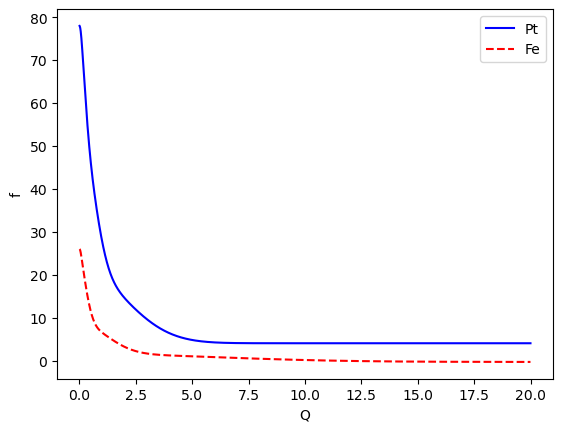

In [4]:
def _f_complex(element,qmin,qmax,qstep,wavelength):
    # définition du tableau de valeurs de q
    qarray=np.arange(qmin,qmax,qstep)
    # Calcul de f0
    f0=_f0(qmin,qmax,qstep,element)
    # Calcul de la composante dispersive f1+frel+fNT
    fdisp=atomicformfactor_nist(element,wavelength)
    f1=fdisp[0]
    fNT=fdisp[1]
    frel=fdisp[2]
    f2=fdisp[3]
    
    # Calcul de f sous forme complexe
    f=np.zeros(len(qarray),dtype=np.complex_)
    real=f0+f1+frel+fNT-Z
    imag=np.full_like(f0,f2)
    f=real+imag*1j
    
    return f


qmin=0.005
qmax=20
qstep=0.01
q_array=np.arange(qmin,qmax,qstep)
wavelength=0.7107
f_pt=_f_complex('Pt',qmin,qmax,qstep,wavelength)
f_fe=_f_complex('Fe',qmin,qmax,qstep,wavelength)

f0_pt=xraydb.f0('Pt',q_array)
f0_fe=xraydb.f0('Fe',q_array)

#plt.plot(q_array,f_pt.real,'-b',label='Pt')
#plt.plot(q_array,f_fe.real,'--r',label='Fe')
plt.plot(q_array,f0_pt,'-b',label='Pt')
plt.plot(q_array,f0_fe,'--r',label='Fe')
plt.xlabel('Q')
plt.ylabel('f')
plt.legend()
plt.show()

### Test du code et comparaison avec les calculs effectués avec Debyer

L'idée est maintenant de faire un calcul de l'intensité diffusée par une particule icosahédrique d'argent de 4 couches. Pour ce faire, on utilisera les algorithmes de calcul d'équation de Debye développés par A. Boule ou le prgramme debyer. Les 3 hypothèses suivantes seront explorées:
- Calcul avec $f_0$ (composante non dispersive uniquement) en utilisant l'algorithme A. Boule
- Calcul avec $f$ tel que calculé ci dessus, c'est à dire en tenant compte de la composante dispersive du facteur de diffusion en utilisant l'algorithme d'A. Boule
- Calcul avec le logiciel Debyer

Dans un premier temps, il faut créer la structure icosahédrique et récupérer les coordonnées des atomes


In [5]:
from ase.cluster import Icosahedron

ico=Icosahedron(element,4,4.0855)
xyz_coords=ico.get_positions()

#number of atoms
N,dim=np.shape(xyz_coords)

q=np.arange(qmin,qmax,qstep)


On recopie maintenant les fonctions crées par A. Boule

In [6]:
@nb.jit(nb.float64[:](nb.float64[:,:]), nopython=True, fastmath=True, parallel=True)
def r_ij(coords):
    r = np.zeros(int((N*N-N)/2), dtype=nb.float64)
    for i in nb.prange(N):
        for j in range(i+1,N):
            l = int(i * (N - 1) - i * (i + 1) / 2 + j - 1)
            tmp = 0.0
            for k in range(dim):
                tmp += (coords[i,k]-coords[j,k])**2
            r[l] = tmp**0.5
    return r
r=r_ij(xyz_coords)

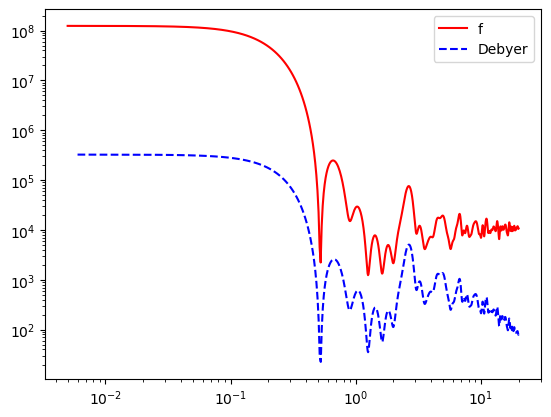

In [7]:
fcomplex=_f_complex(element,qmin,qmax,qstep,wavelength)

# Comme on fait appel à des nombres complexes, la ligne d'entête de numba est différente.
# Il est donc nécessaire de redéfinir la fonction Debye


@nb.jit(nb.float64[:](nb.float64[:], nb.float64[:], nb.int64, nb.complex128[:]),
        nopython=True, fastmath=True, parallel=True)

def Debye_complex(Q,r,N,f_at):
    
    res = np.zeros(int(len(Q)), dtype = nb.float64)
    for i_Q in nb.prange(len(Q)):
        tmp = 0.0
        for i_r in range(len(r)): #"for v_r in r" doens't work (probably bc r is float)
            tmp += math.sin(Q[i_Q]*r[i_r])/(Q[i_Q]*r[i_r])
        res[i_Q] = (N + 2*tmp)*abs(f_at[i_Q])**2
    return res


iq_fcomplex=Debye_complex(q,r,N,fcomplex)

#import debyer data
q_debyer,i_debyer=np.loadtxt('Ag_Icosahedron_4shells.sq',unpack=True)

### Plot it
plt.loglog(q,iq_fcomplex,'-r',label='f')
plt.loglog(q_debyer,i_debyer,'--b',label='Debyer')
plt.legend()
plt.show()